**VISUALISATIONS**
-------

In this notebook, we will visualise the the distribution of our features

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

Plotting the locations of schools

In [50]:
def feat_sf (shapefile, feature_name, feat_type = None, feat_subtypes = None):
    """
    Cleaning shapefiles and dataframes for features we want.

    Args:
        shapefile (gpd.Geodataframe or pd.dataframe): the file with information on neighbourhood features
        feature_name (str): name of the feature
        feat_type (str or list, optional): any specific types of feature we want. Defaults to None.
        feat_subtypes (list, optional): feature subtypes, for example, a chicken is a subtype of a bird . Defaults to None.

    Raises:
        ValueError: feature name is wrong and not mentioned

    Returns:
        gpd.Geodataframe or pd.dataframe: the cleaned shapefile or dataframe
    """
    if feature_name in ("primary_school", "secondary_school", "school"):
        if feat_subtypes != None:
            raise ValueError("feat_subtypes must be none for school gdfs.")
        if feat_type == None and feature_name == "school":
            filtered_sf = shapefile.copy()
        elif feat_type != None and feature_name in ("primary_school", "secondary_school"):
            filtered_sf = shapefile[shapefile['School_Type'].isin(feat_type)]
        else: 
            raise ValueError("feat_type must be none for feature_name = \"school\" or \
                must have feat_type for to specify type of school.")
        # Renaming columns for ease of use for future functions
        filtered_sf = filtered_sf.rename(columns={'School_Name': 'NAME'})
        # Convert the school data into a GeoDataFrame using the Y (latitude) and X (longitude) columns
        filtered_sf = filtered_sf.rename(columns={'Y': 'latitude'})
        filtered_sf = filtered_sf.rename(columns={'X': 'longitude'})
        filtered_sf['geometry'] = gpd.points_from_xy(filtered_sf['longitude'], filtered_sf['latitude'])
        filtered_sf = gpd.GeoDataFrame(filtered_sf, geometry='geometry')
        filtered_sf = filtered_sf.set_crs(epsg=4326, inplace=True)
    else:
        if feature_name == "train_station":
            if feat_subtypes != None or feat_type != None:
                raise ValueError("Both feat_type and feat_subtypes must be none.")
            filtered_sf = shapefile[shapefile['STATUS'] == "Active"]
            # Renaming columns for ease of use for future functions
            filtered_sf = filtered_sf.rename(columns={'STATION': 'NAME'})
        elif feature_name in ("shopping", "parks", "hospital"):
            if feat_subtypes == None or feat_type == None:
                raise ValueError("Both feat_type and feat_subtypes must have value.")
            # We only want features in VIC
            filtered_sf = shapefile[shapefile['STATE'] == "VIC"]
            filtered_sf = filtered_sf[filtered_sf['FTYPE'] == feat_type]
            filtered_sf = filtered_sf[filtered_sf['FEATSUBTYP'].isin(feat_subtypes)]
        else:
            raise ValueError("Invalid feature_name provided.")
            # Setting shapefile format
        filtered_sf['geometry'] = filtered_sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
        # Creating an array of centroids of polygons in the feature shapefiles
        filtered_sf['centroid'] = filtered_sf['geometry'].centroid.apply(lambda geom: (geom.y, geom.x))
        filtered_sf['latitude'] = filtered_sf['centroid'].apply(lambda coord: coord[0])
        filtered_sf['longitude'] = filtered_sf['centroid'].apply(lambda coord: coord[1])
    
    filtered_sf = filtered_sf.dropna(subset=['latitude', 'longitude']).copy()
    filtered_sf = filtered_sf.to_crs(epsg=4326)
    return filtered_sf.reset_index(drop=True)

def state_plot(state_gdf, feat_sf, feature_name, plot_title_name, if_centroid = None, if_zoom = None):
    """
    Creates plot of features in the state

    Args:
        state_gdf (gpd.GeoDataFrame): A shapefile of the state's suburb boundaries
        feat_sf (gpd.GeoDataFrame): A gdf of the feature
        feature_name (str): Name you want the feature to be saved as
        plot_title_name (str): Name you want to print the feature as
        if_centroid (str, optional): Plot the centroids as dots, otherwise plot the polygon shapes. 
                                        Defaults to None.
        if_zoom (str, optional): If need to zoom in. Defaults to None.
    """
    # Check if file exists
    state_plot_dir = "../plots/state_plots"
    os.makedirs(state_plot_dir, exist_ok=True)
    
    # Reproject Victoria's and feature shapefile to match CRS (if necessary)
    state_gdf = state_gdf.to_crs(epsg=4326)
    feat_sf = feat_sf.to_crs(epsg=4326)
    
    # Plot both the Victoria boundary and feature locations
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot Victoria boundaries
    state_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

    # Plot features on top, plot polygons if no centroid flag.
    if if_centroid != None:
        feat_sf.centroid.plot(ax=ax, color='blue', markersize=5,  label=plot_title_name)
    else: 
        feat_sf.plot(ax=ax, color='blue', markersize=5,  label=plot_title_name)
        
    if if_zoom != None:
        # Set bounds if zoomed in
        bounds = feat_sf.total_bounds
        # Set limits to zoom in on the area with train stations
        ax.set_xlim([144.12, 145.75]) 
        ax.set_ylim([-38.6, -37.5]) 
        # Rename plot title if zoomed in
        plt.title(f'{plot_title_name} in Victoria (Zoomed In)')
    else:
        plt.title(f'{plot_title_name} in Victoria')
    
    # Set plot labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    # Save the plot as a png file
    plt.savefig(f"{state_plot_dir}/state_{feature_name}_map.png", format='png', dpi=300)

    return plt.show()


def heatmap_plot(feat_sf, state_gdf, feature_name, plot_title_name):
    """
    Creates a heatmap of the count of the features in a suburb in metropolitan melbourne

    Args:
        feat_sf (gpd.GeoDataFrame): A gdf of the feature        
        state_gdf (gpd.GeoDataFrame): A shapefile of the state's suburb boundaries
        feature_name (str): Name you want the feature to be saved as
        plot_title_name (str): Name you want to print the feature as
    """
    # Check if file exists
    heatmap_dir = "../plots/heatmap_plots"
    os.makedirs(heatmap_dir, exist_ok=True)
    
    # Set minimum and maximum boundaries
    minx, miny, maxx, maxy = 144.5, -38.1, 145.3, -37.5
    # Set feature count column name
    name = f'{feature_name}_count'
    
    # Reproject the Victoria shapefile to match the CRS of the school data (if necessary)
    victoria_gdf = state_gdf[state_gdf['STE_CODE21'] == '2']
    victoria_gdf = victoria_gdf.to_crs(epsg=4326)

    # Perform a spatial join to assign each feature to its respective SA2 area (use 'predicate' instead of 'op')
    schools_in_sa2 = gpd.sjoin(feat_sf, victoria_gdf, how='inner', predicate='within')

    # Count the number of the feature in each SA2 area
    schools_per_sa2 = schools_in_sa2.groupby('SA2_NAME21').size().reset_index(name=name)

    # Merge the counts with the Victoria SA2 GeoDataFrame
    victoria_gdf = victoria_gdf.merge(schools_per_sa2, on='SA2_NAME21', how='left')

    # Fill NaN values with 0 (areas with no schools)
    victoria_gdf[name] = victoria_gdf[name].fillna(0)

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot SA2 regions, with the color based on the number of features
    victoria_gdf.plot(column=name, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    # Set the limits to zoom in to metro Melbourne
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Set plot title and labels
    plt.title(f'Number of {plot_title_name} in Metro Melbourne SA2 Areas', fontsize=16)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Save the plot as a png file
    plt.savefig(f"{heatmap_dir}/{feature_name}_metro_heatmap.png", format='png', dpi=300)

    return plt.show()

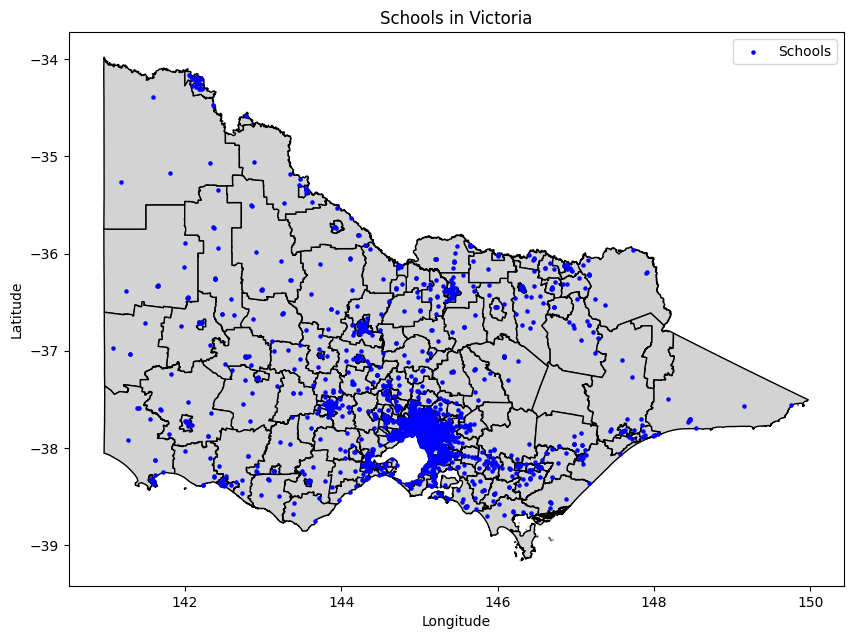

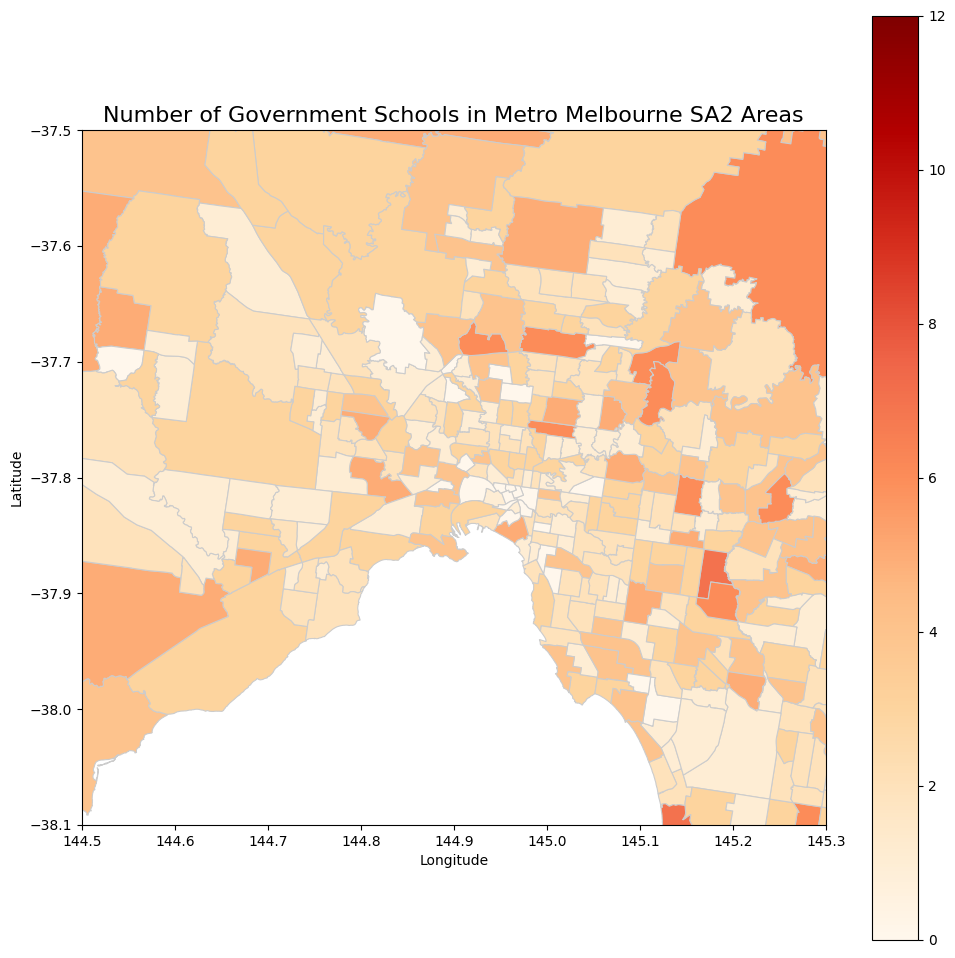

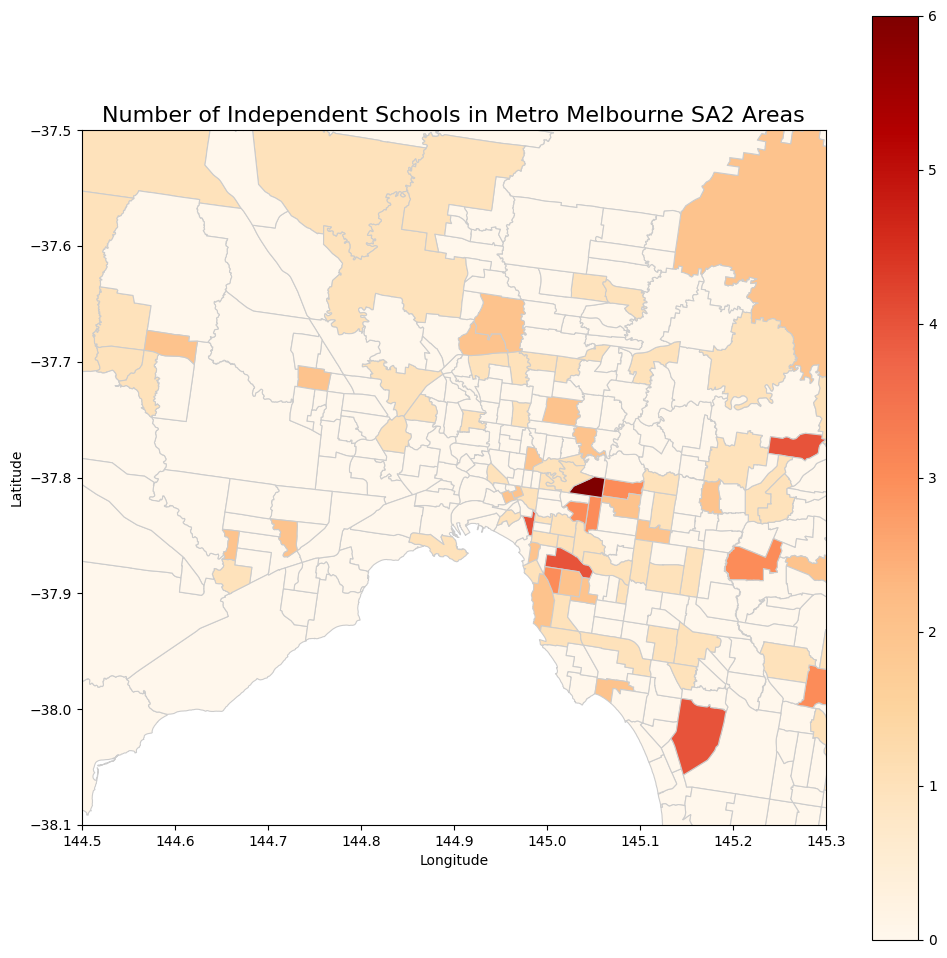

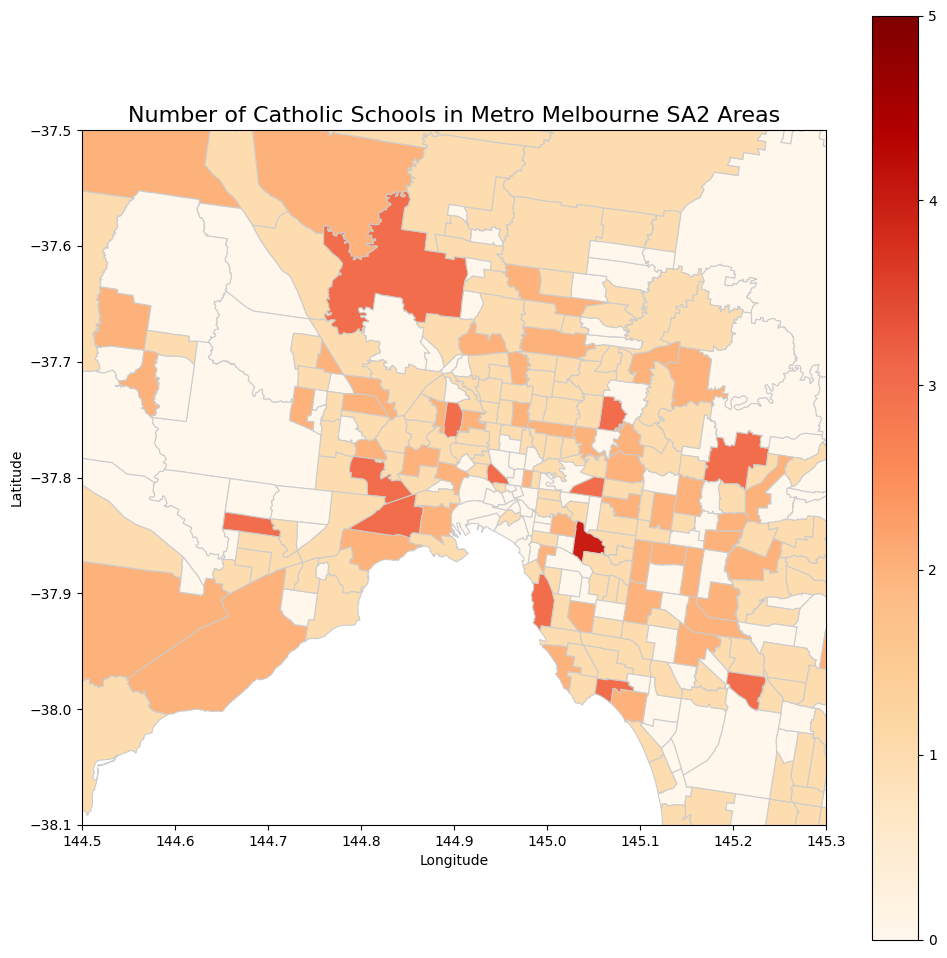

/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_4661/3429807231.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  filtered_sf['centroid'] = filtered_sf['geometry'].centroid.apply(lambda geom: (geom.y, geom.x))


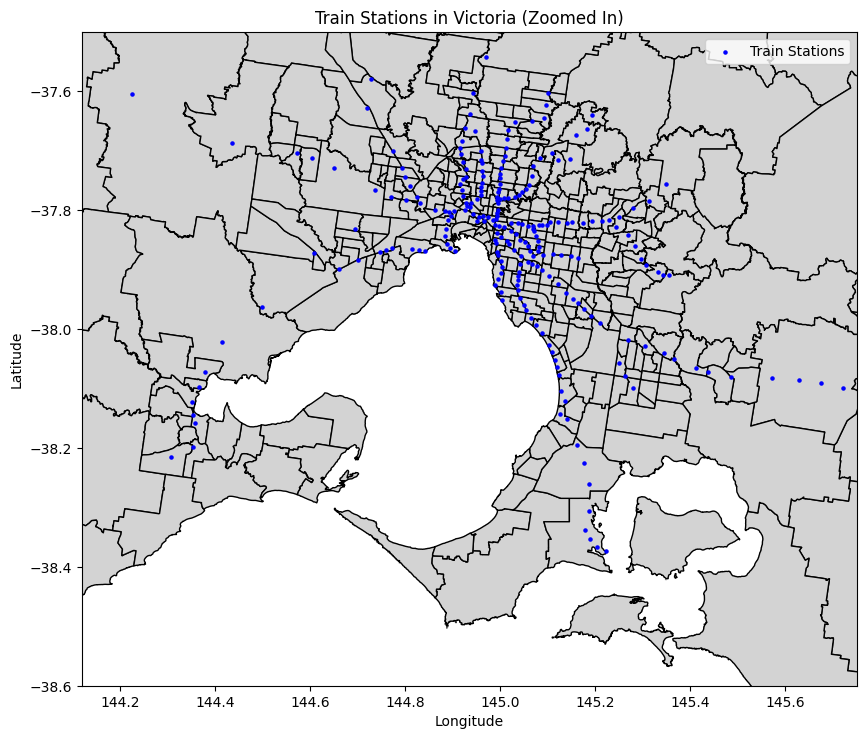

/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_4661/3429807231.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  filtered_sf['centroid'] = filtered_sf['geometry'].centroid.apply(lambda geom: (geom.y, geom.x))
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_4661/3429807231.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feat_sf.centroid.plot(ax=ax, color='blue', markersize=5,  label=plot_title_name)


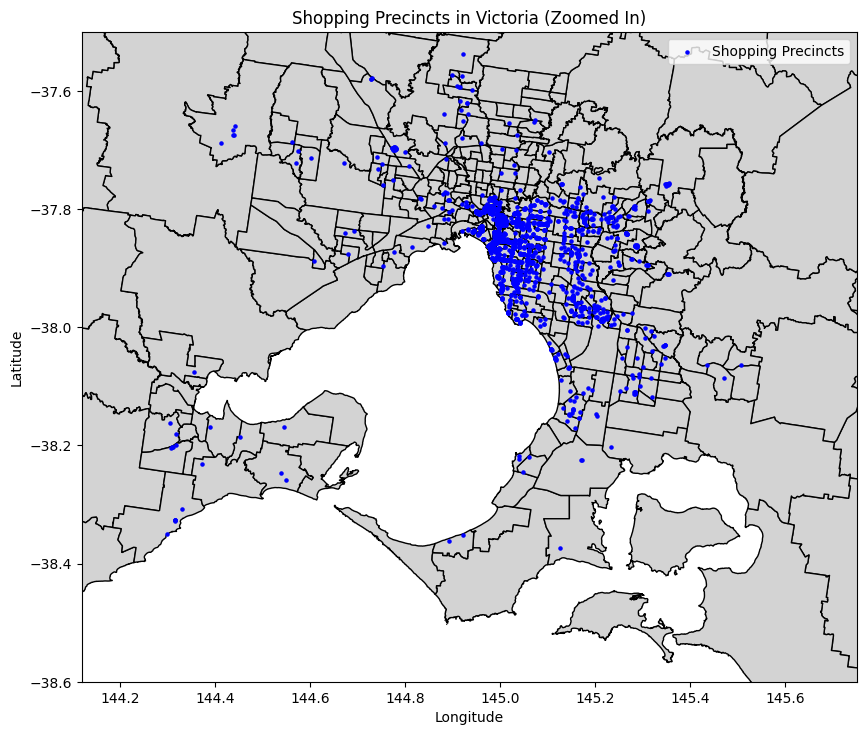

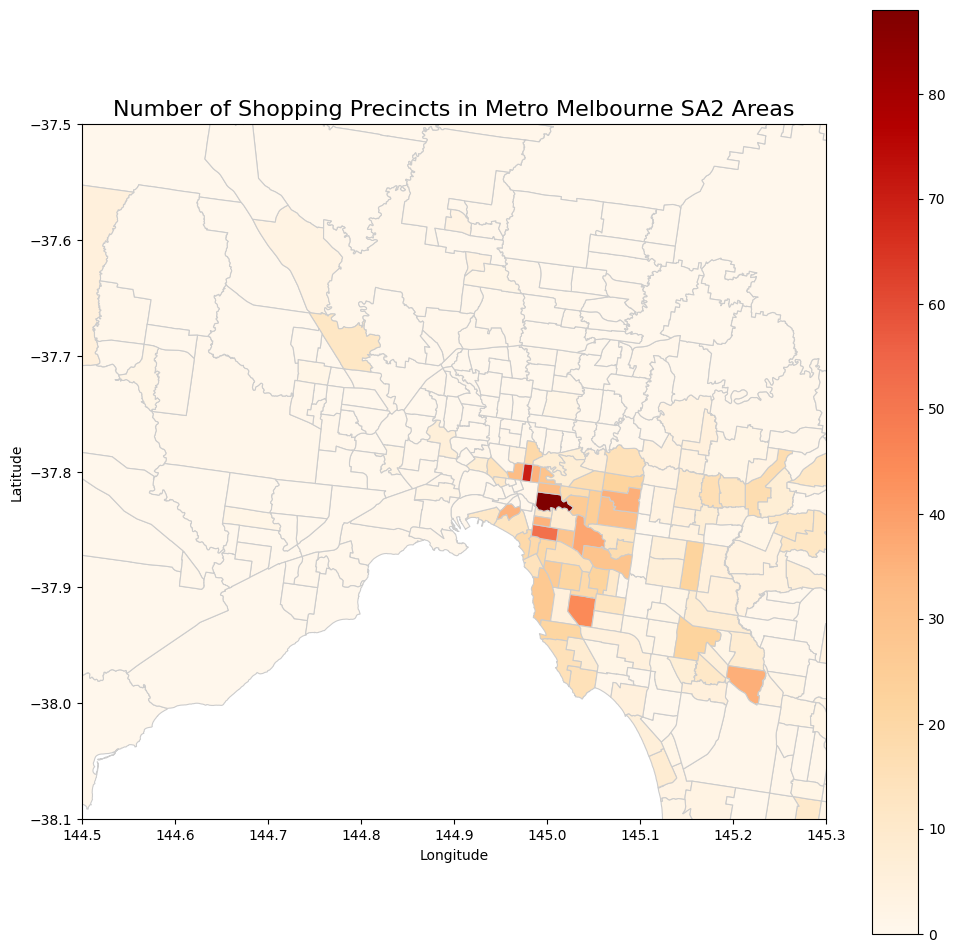

/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_4661/3429807231.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  filtered_sf['centroid'] = filtered_sf['geometry'].centroid.apply(lambda geom: (geom.y, geom.x))
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_4661/3429807231.py:109: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_4661/3429807231.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


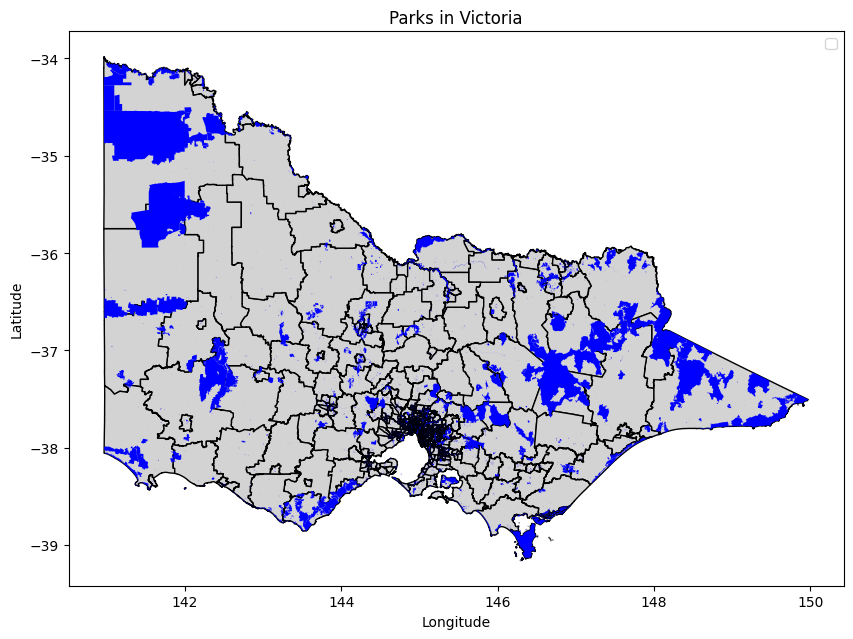

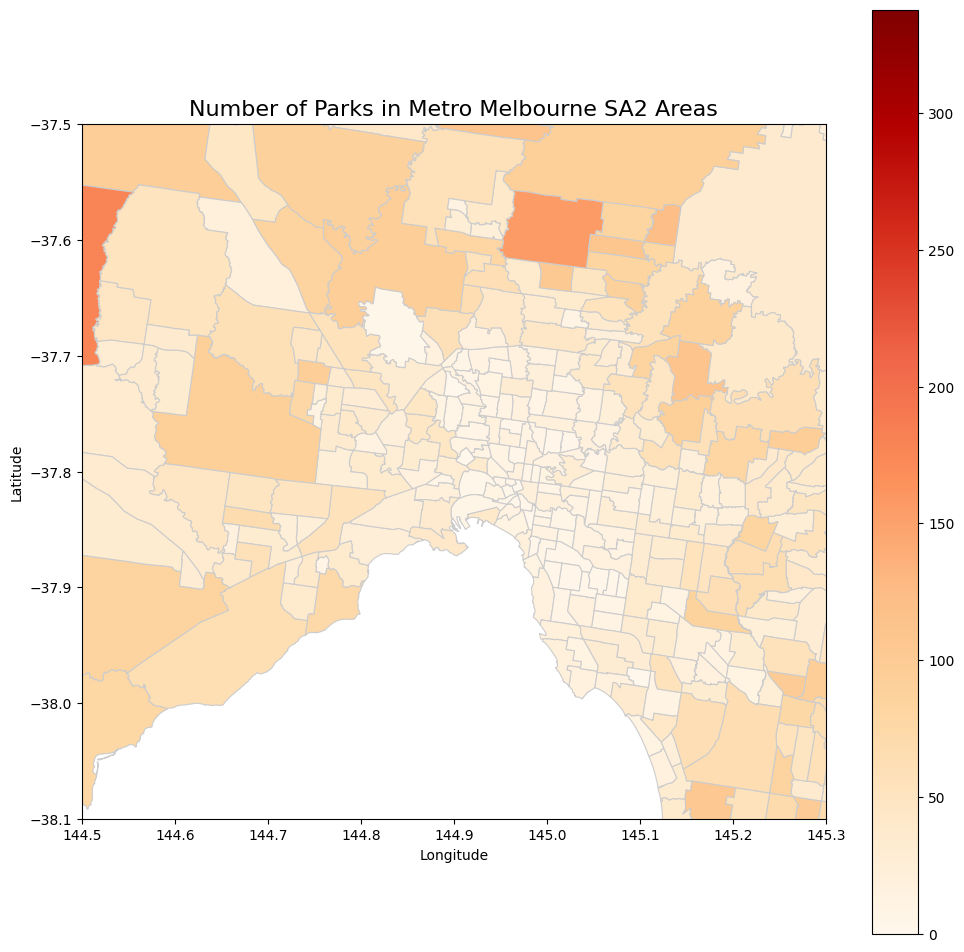

/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_4661/3429807231.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  filtered_sf['centroid'] = filtered_sf['geometry'].centroid.apply(lambda geom: (geom.y, geom.x))
/var/folders/gd/m0kqkz893_x6z1pmcms3kw_r0000gn/T/ipykernel_4661/3429807231.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  feat_sf.centroid.plot(ax=ax, color='blue', markersize=5,  label=plot_title_name)


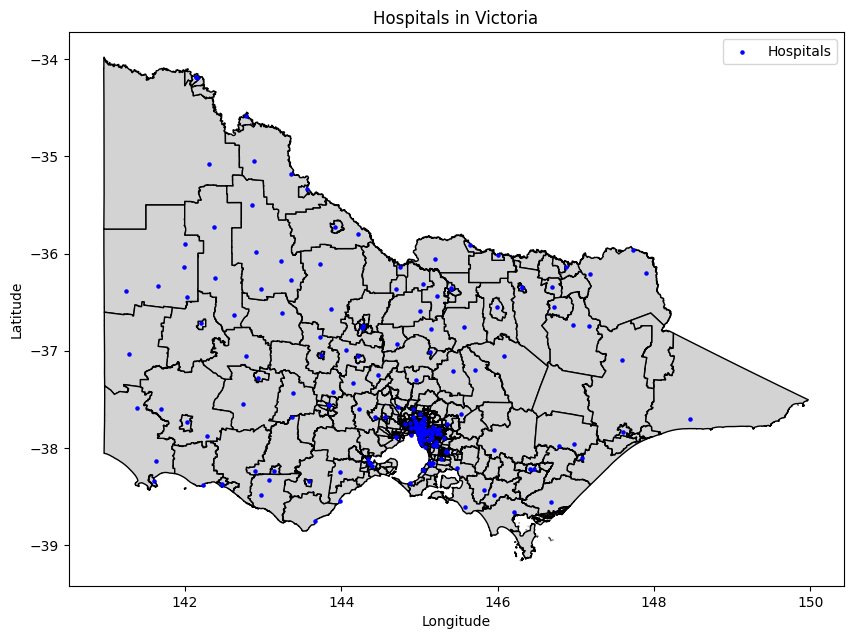

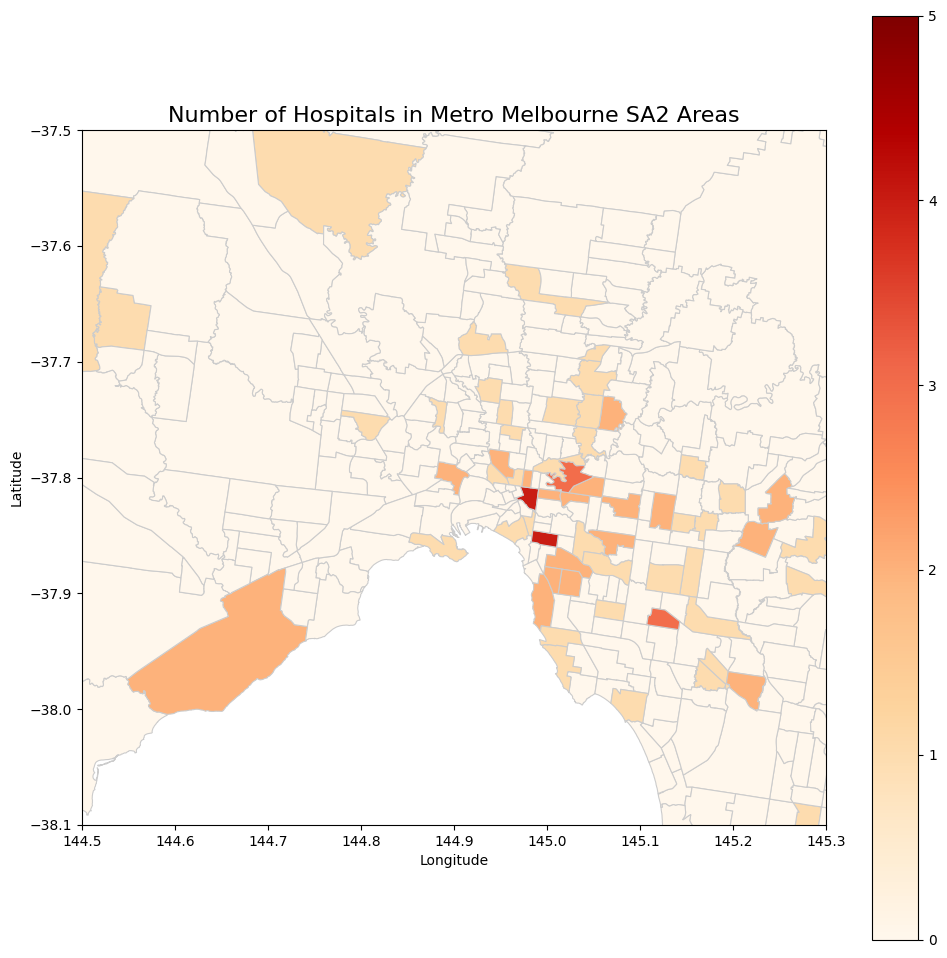

In [51]:
# Directories
data_dir = '../data/'
landing_dir = data_dir + 'landing/'
raw_dir = data_dir + 'raw/'

# Load the Victoria boundary spatial data (SA2 shapefile)
sa2_path = f'{raw_dir}sa2_shapefile/SA2_2021_AUST_GDA2020.shp'
gdf = gpd.read_file(sa2_path)

# Set state to Victoria
victoria_gdf = gdf[gdf['STE_CODE21'] == '2']

school_feature = "school"
# Load the school data with the correct encoding
school_df = pd.read_csv(f"{landing_dir}dv346-schoollocations2023.csv", encoding = "ISO-8859-1")
# Clean shapefile
school_gdf = feat_sf (school_df, school_feature) 
# Create plot
state_plot(victoria_gdf, school_gdf, school_feature,  "Schools")
# Heatmap plots of different types of schools
heatmap_plot(school_gdf[school_gdf['Education_Sector'] == "Government"], gdf, "government_school", "Government Schools")
heatmap_plot(school_gdf[school_gdf['Education_Sector'] == "Independent"], gdf, "indepedent_school", "Independent Schools")
heatmap_plot(school_gdf[school_gdf['Education_Sector'] == "Catholic"], gdf, "catholic_school", "Catholic Schools")

ptv_sf = gpd.read_file(f"{landing_dir}PTV/VIC_RAILWAY_STATIONS.shp")
train_station_feature = "train_station"
# Clean shapefile
train_station_gdf = feat_sf(ptv_sf, train_station_feature)
# Create plot
state_plot(victoria_gdf, train_station_gdf, train_station_feature, "Train Stations", if_zoom = "yes")

foi_sf = gpd.read_file(f"{landing_dir}FOI/GEOMARK_POLYGON.shp")
shopping_type = "commercial facility"
shopping_feature = "shopping"
shopping_labels = ["shopping precinct", "shopping centre"]
# Clean shapefile
shopping_sf = feat_sf(foi_sf, shopping_feature, shopping_type, shopping_labels)
# Create plot
state_plot(victoria_gdf, shopping_sf, shopping_feature, "Shopping Precincts", if_centroid = "yes", if_zoom = "yes")
# Create heatmap plot
heatmap_plot(shopping_sf, victoria_gdf, shopping_feature, "Shopping Precincts")


parks_type = "reserve"
parks_feature = "parks"
parks_labels = ["park", "conservation park", "gardens", "national park", "city square"]
# Clean shapefile
parks_sf = feat_sf(foi_sf, parks_feature, parks_type, parks_labels)
# Create plot
state_plot(victoria_gdf, parks_sf, parks_feature , parks_feature.capitalize())
# Create heatmap plot
heatmap_plot(parks_sf, victoria_gdf, parks_feature, parks_feature.capitalize())


hospital_type = "hospital"
hospital_feature = "hospital"
hospital_labels = ["hospital complex"]
# Clean shapefile
hospital_sf = feat_sf(foi_sf, hospital_feature, hospital_type, hospital_labels)
# Create plot
state_plot(victoria_gdf, hospital_sf, hospital_feature, "Hospitals", if_centroid = "yes")
# Create heatmap plot
heatmap_plot(hospital_sf, victoria_gdf, hospital_feature, "Hospitals")
